In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#get the rf-boruta results
df_infer = pd.read_csv('../out/20.0216 feat/reg_rf_boruta/anlyz_filtered/feat_summary_varExp_filtered.csv')

#get the reg univariate-rf results
df_assoc = pd.read_csv('../out/20.0216 feat/reg_univariate_rf/anlyz_filtered/univariate_varExp_filtered.csv')

#L100 results
df_L100 = pd.read_csv('../out/19.1013 tight cluster/landmarks_n100_k100.csv')

In [3]:
genes_assoc = set(df_assoc.target.unique()).union(set(df_assoc.feat_gene.unique()))
genes_infer = set(df_infer.target.unique()).union(set(df_infer.feat_gene.unique()))

genes_intersect = genes_assoc.intersection(genes_infer)

In [4]:
pd.DataFrame([{'intersect':len(genes_intersect),
               'genes_assoc':len(genes_assoc),
               'genes_infer':len(genes_infer)}])

,genes_assoc,genes_infer,intersect
0,2782,2987,1731


In [5]:
#get the group-only genes
assoc_only = genes_assoc - genes_infer
infer_only = genes_infer - genes_assoc

In [6]:
#retrieve the genes L100
df_L100['genes_token'] = df_L100.genes.apply(lambda x: re.findall('(\w*)\.\.', x))
df_L100['genes_token'] = df_L100.apply(lambda x: re.findall('(\w*)\s', x['landmark'])+x['genes_token'], axis=1)
df_L100.head()

,cluster,genes,size,landmark,genes_token
0,1,"ABHD8..79575.,ACP5..54.,ACTL9..284382.,ADAMTS1...",224,TMEM167A (153339),"[TMEM167A, ABHD8, ACP5, ACTL9, ADAMTS10, AKAP8..."
1,2,"AADAT..51166.,ABAT..18.,ACTL6B..51412.,ADHFE1....",226,CDC40 (51362),"[CDC40, AADAT, ABAT, ACTL6B, ADHFE1, AEBP2, AF..."
2,3,"AASS..10157.,ADI1..55256.,ADO..84890.,AES..166...",261,PBRM1 (55193),"[PBRM1, AASS, ADI1, ADO, AES, AGXT, AGXT2, AIM..."
3,4,"ACTR5..79913.,ADRM1..11047.,AICDA..57379.,ARID...",182,PDS5A (23244),"[PDS5A, ACTR5, ADRM1, AICDA, ARID1B, ARID3C, A..."
4,5,"ABT1..29777.,ACD..65057.,ACTR8..93973.,AFF1..4...",173,SMARCE1 (6605),"[SMARCE1, ABT1, ACD, ACTR8, AFF1, AFF4, AIP, A..."


In [7]:
#get interactions with L100
#expect that assoc_only genes to be more associated within L100 clusters
#expect infer_only to be more across L100 clusters

df_L100['intersect_assoc_only'] = df_L100.genes_token.apply(lambda x: len(set.intersection(set(x), set(assoc_only))))
df_L100['intersect_infer_only'] = df_L100.genes_token.apply(lambda x: len(set.intersection(set(x), set(infer_only))))
df_L100['intersect_assoc'] = df_L100.genes_token.apply(lambda x: len(set.intersection(set(x), set(genes_assoc))))
df_L100['intersect_infer'] = df_L100.genes_token.apply(lambda x: len(set.intersection(set(x), set(genes_infer))))


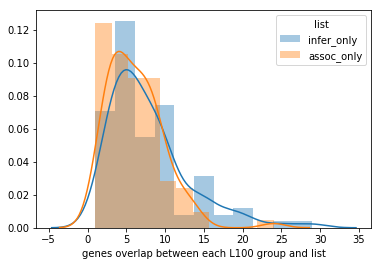

In [8]:
sns.distplot(df_L100.intersect_infer_only)
sns.distplot(df_L100.intersect_assoc_only)
plt.legend(title='list',loc='upper right', labels=['infer_only', 'assoc_only'])
plt.xlabel('genes overlap between each L100 group and list')
plt.show()

There is a slight skew for the association-based method to have higher intra-group L100 overlap

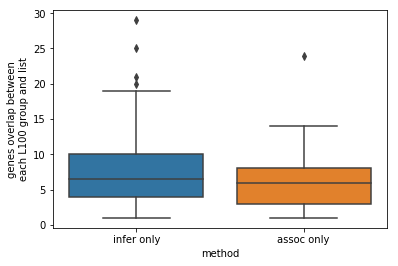

In [9]:
df1 = pd.DataFrame({'val':df_L100.intersect_infer_only, 'method':'infer only'})
df2 = pd.DataFrame({'val':df_L100.intersect_assoc_only, 'method':'assoc only'})
df = pd.concat([df1,df2])
sns.boxplot('method', 'val', data = df)
plt.ylabel('genes overlap between\neach L100 group and list')
plt.show()

In [10]:
from scipy.stats import mannwhitneyu 
mannwhitneyu(df_L100.intersect_infer_only, df_L100.intersect_assoc_only)

MannwhitneyuResult(statistic=4117.0, pvalue=0.015184803703018685)

Check not just the infer/assoc only genes, but all infer genes, and all assoc genes

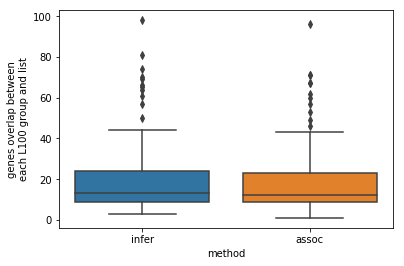

In [11]:
df1 = pd.DataFrame({'val':df_L100.intersect_infer, 'method':'infer'})
df2 = pd.DataFrame({'val':df_L100.intersect_assoc, 'method':'assoc'})
df = pd.concat([df1,df2])
sns.boxplot('method', 'val', data = df)
plt.ylabel('genes overlap between\neach L100 group and list')
plt.show()

In [12]:
from scipy.stats import mannwhitneyu 
mannwhitneyu(df_L100.intersect_infer, df_L100.intersect_assoc)

MannwhitneyuResult(statistic=4719.0, pvalue=0.2462946536162302)

Not significant here. But significant when you compare/contrast infer only and assoc only (excluding their intersections), to the L100; p-value = 0.15